In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data=pd.read_csv('Fusion_data3.csv')

In [3]:
def category(x):
    if x=='clickbait':
        return 1
    else :
        return 0

In [23]:
data.label=data.label.apply(lambda x:category(x))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Unnamed: 0','label']), data['label'], test_size=1/3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.8, random_state=42)

In [29]:
X_train.sample()

,p_title,sent_length,word_length,Stops_ratio,Num_Punctuation,category_Berita,category_Ekonomi&Bisnis,category_Lain,category_Lifestyle,category_Olahraga,...,source_fimela.com,source_kapanlagi.com,source_liputan6.com,source_okezone.com,source_posmetro-medan.com,source_republika.co.id,source_sindonews.com,source_tempo.co,source_tribunnews.com,source_wowkeren.com
13094,kepala bppt bj habibie merupakan bapak teknolo...,8,5.75,0.375,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Embedding

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split
# Limit on the number of features to K features.
data=pd.read_csv('Fusion_data3.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Unnamed: 0','label']), data['label'], test_size=1/3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.8, random_state=42)
TOP_K = 20000
# Limit on the length of text sequences. 
# Sequences longer than this will be truncated.
# and less than it will be padded
MAX_SEQUENCE_LENGTH = 20

class CustomTokenizer:
    def __init__(self, train_texts):
        self.train_texts = train_texts
        self.tokenizer = Tokenizer(num_words=TOP_K)
        
    def train_tokenize(self):
        # Get max sequence length.
        max_length = len(max(self.train_texts , key=len))
        self.max_length = min(max_length, MAX_SEQUENCE_LENGTH)
    
        # Create vocabulary with training texts.
        self.tokenizer.fit_on_texts(self.train_texts)
        
    def vectorize_input(self, news):
        # Vectorize training and validation texts.
        
        news = self.tokenizer.texts_to_sequences(news)
        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        news = pad_sequences(news, maxlen=self.max_length, truncating='post',padding='post')
        return news
    
tokenizer = CustomTokenizer(train_texts = X_train['p_title'])
# fit o the train
tokenizer.train_tokenize()
tokenized_train = tokenizer.vectorize_input(X_train['p_title'])
tokenized_val=tokenizer.vectorize_input(X_val['p_title'])
tokenized_test = tokenizer.vectorize_input(X_test['p_title'])

Using TensorFlow backend.


In [5]:
glove_file='idwiki_word2vec_200.txt'
EMBEDDING_VECTOR_LENGTH = 200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file, 'r', errors="ignore") as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix
  
embedding_matrix =  construct_embedding_matrix(glove_file, tokenizer.tokenizer.word_index)

100%|████████████████████████████████████████████████████████████████████████| 14510/14510 [00:00<00:00, 234454.06it/s]


# Models

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras import backend as K

## Self Attentive Network + Structured Variable

In [10]:
tf.compat.v1.disable_eager_execution()

In [28]:
class attention(tf.keras.layers.Layer): 
    def __init__(self):    
        super(attention, self).__init__()
        
    def build(self, input_shape):
        self.num_dim_perword = input_shape[-1] ##Last value of inp:256
        self.W_1 = self.add_weight(shape=(self.num_dim_perword,self.num_dim_perword),initializer=tf.keras.initializers.GlorotNormal())
        self.W_2 = self.add_weight(shape=(self.num_dim_perword,1),initializer=tf.keras.initializers.GlorotNormal())
        super(attention, self).build(input_shape)
        
    def call(self, x):
        e = K.dot(K.tanh(K.dot(x,self.W_1)),self.W_2)
        a = K.softmax(e, axis=1)
        output = x*a
        return output

In [31]:
inputs_word = tf.keras.Input(shape=(20,))
word = tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    200,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False)(inputs_word)
word=tf.keras.layers.Dropout(0.2)(word)
word=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),merge_mode='concat')(word)
word = tf.keras.Model(inputs=inputs_word, outputs=word)
inputs_other= tf.keras.Input(shape=(25,))
model=tf.keras.layers.concatenate([word.output, inputs_other])
model=attention()(model)
model=tf.keras.layers.Dense(1,activation='sigmoid')(model)
model= tf.keras.Model(inputs=[word.input, inputs_other], outputs=model)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 200)      2910000     input_7[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 20, 200)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 200)          240800      dropout_3[0][0]                  
____________________________________________________________________________________________

In [32]:
optimizer= tf.keras.optimizers.Adam(clipvalue=2,learning_rate=0.005)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])

In [33]:
i_train = [tokenized_train,X_train.drop(columns=['p_title']).to_numpy()]
i_val= [tokenized_val,X_val.drop(columns=['p_title']).to_numpy()]
i_test= [tokenized_test,X_test.drop(columns=['p_title']).to_numpy()]

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
histori = model.fit(x=i_train,y=y_train,validation_data=(i_val,y_val),
                    epochs=20, batch_size=64, callbacks=[callback],
                    verbose=2)

Train on 10050 samples, validate on 1980 samples
Epoch 1/20
10050/10050 - 20s - loss: 0.4984 - accuracy: 0.7602 - val_loss: 0.4201 - val_accuracy: 0.7990
Epoch 2/20
10050/10050 - 19s - loss: 0.3914 - accuracy: 0.8222 - val_loss: 0.3934 - val_accuracy: 0.8192
Epoch 3/20
10050/10050 - 19s - loss: 0.3450 - accuracy: 0.8518 - val_loss: 0.3917 - val_accuracy: 0.8187
Epoch 4/20
10050/10050 - 19s - loss: 0.3175 - accuracy: 0.8647 - val_loss: 0.3880 - val_accuracy: 0.8273
Epoch 5/20
10050/10050 - 19s - loss: 0.2972 - accuracy: 0.8707 - val_loss: 0.4011 - val_accuracy: 0.8258
Epoch 6/20
10050/10050 - 19s - loss: 0.2877 - accuracy: 0.8757 - val_loss: 0.4446 - val_accuracy: 0.8091
Epoch 7/20
10050/10050 - 19s - loss: 0.2591 - accuracy: 0.8902 - val_loss: 0.4216 - val_accuracy: 0.8212


In [35]:
import matplotlib.pyplot as plt

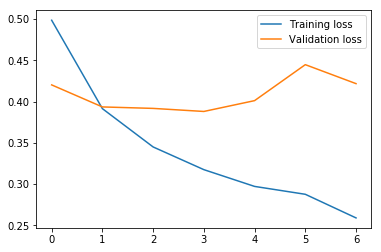

In [36]:
plt.plot(histori.history['loss'],label='Training loss')
plt.plot(histori.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

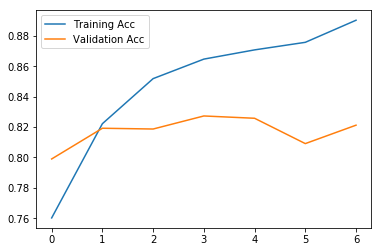

In [37]:
plt.plot(histori.history['accuracy'],label='Training Acc')
plt.plot(histori.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.show()

In [38]:
a_mean,a_std=np.mean(histori.history['accuracy']),np.std(histori.history['accuracy'])
l_mean,l_std=np.mean(histori.history['loss']),np.std(histori.history['loss'])
av_mean,av_std=np.mean(histori.history['val_accuracy']),np.std(histori.history['val_accuracy'])
lv_mean,lv_std=np.mean(histori.history['val_loss']),np.std(histori.history['val_loss'])
print('RNN (SA-BiLSTM + Structured Data)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (SA-BiLSTM + Structured Data)
Training
Accuracy : 0.848 (+-0.041) Loss : 0.342 (+-0.075)
Validation
Accuracy : 0.817 (+-0.009) Loss : 0.409 (+-0.019)


In [39]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0
y_pred=np.array([[float_int(i[0])] for i in model.predict(i_test)])

In [40]:
from sklearn.metrics import classification_report,confusion_matrix
test_loss,test_accuracy=model.evaluate(i_test,y_test)
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print(classification_report(y_test,y_pred))

Test Loss : 0.457
Test Accuracy : 0.813
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1726
           1       0.79      0.76      0.77      1244

    accuracy                           0.81      2970
   macro avg       0.81      0.81      0.81      2970
weighted avg       0.81      0.81      0.81      2970



## Self Attentive Network

In [41]:
class attention(tf.keras.layers.Layer): 
    def __init__(self):    
        super(attention, self).__init__()
        
    def build(self, input_shape):
        self.num_dim_perword = input_shape[-1] ##Last value of inp:256
        self.W_1 = self.add_weight(shape=(self.num_dim_perword,self.num_dim_perword),initializer=tf.keras.initializers.GlorotNormal())
        self.W_2 = self.add_weight(shape=(self.num_dim_perword,1),initializer=tf.keras.initializers.GlorotNormal())
        super(attention, self).build(input_shape)
        
    def call(self, x):
        e = K.dot(K.tanh(K.dot(x,self.W_1)),self.W_2)
        a = K.softmax(e, axis=1)
        output = x*a
        return K.sum(output,axis=1)

In [44]:
state_size = 100
dropout= 0.2
optimizer= tf.keras.optimizers.Adam(learning_rate=0.005)
mods1=tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    200,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, dropout=dropout, recurrent_dropout=dropout,return_sequences=True)),
    attention(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
mods1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
mods1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 200)           2910000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 20, 200)           240800    
_________________________________________________________________
attention_5 (attention)      (None, 200)               40200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 3,191,201
Trainable params: 281,201
Non-trainable params: 2,910,000
______________________________________

In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
historie = mods1.fit(tokenized_train,y_train,validation_data=(tokenized_val,y_val),
                    epochs=20, batch_size=64, callbacks=[callback],
                    verbose=2)

Train on 10050 samples, validate on 1980 samples
Epoch 1/20
10050/10050 - 30s - loss: 0.5336 - accuracy: 0.7347 - val_loss: 0.4663 - val_accuracy: 0.7793
Epoch 2/20
10050/10050 - 25s - loss: 0.4731 - accuracy: 0.7795 - val_loss: 0.4740 - val_accuracy: 0.7944
Epoch 3/20
10050/10050 - 25s - loss: 0.4457 - accuracy: 0.7965 - val_loss: 0.4617 - val_accuracy: 0.7848
Epoch 4/20
10050/10050 - 26s - loss: 0.4294 - accuracy: 0.8077 - val_loss: 0.4614 - val_accuracy: 0.7894
Epoch 5/20
10050/10050 - 26s - loss: 0.4181 - accuracy: 0.8125 - val_loss: 0.4647 - val_accuracy: 0.7949
Epoch 6/20
10050/10050 - 28s - loss: 0.4029 - accuracy: 0.8160 - val_loss: 0.4656 - val_accuracy: 0.7980
Epoch 7/20
10050/10050 - 27s - loss: 0.4006 - accuracy: 0.8200 - val_loss: 0.4759 - val_accuracy: 0.7864


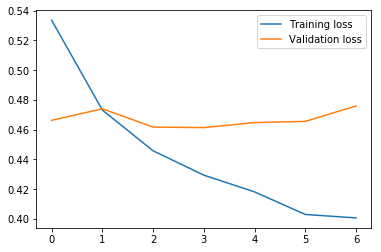

In [46]:
plt.plot(historie.history['loss'],label='Training loss')
plt.plot(historie.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

In [48]:
a_mean,a_std=np.mean(historie.history['accuracy']),np.std(historie.history['accuracy'])
l_mean,l_std=np.mean(historie.history['loss']),np.std(historie.history['loss'])
av_mean,av_std=np.mean(historie.history['val_accuracy']),np.std(historie.history['val_accuracy'])
lv_mean,lv_std=np.mean(historie.history['val_loss']),np.std(historie.history['val_loss'])
print('RNN (SA-BiLSTM)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (SA-BiLSTM)
Training
Accuracy : 0.795 (+-0.028) Loss : 0.443 (+-0.044)
Validation
Accuracy : 0.790 (+-0.006) Loss : 0.467 (+-0.005)


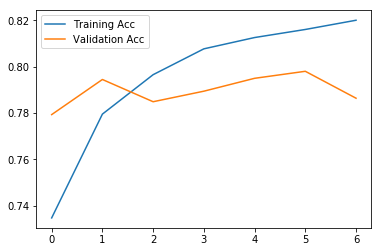

In [49]:
plt.plot(historie.history['accuracy'],label='Training Acc')
plt.plot(historie.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.show()

In [50]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0
y_pred=np.array([[float_int(i[0])] for i in mods1.predict(tokenized_test)])

In [51]:
from sklearn.metrics import classification_report,confusion_matrix
test_loss,test_accuracy=mods1.evaluate(tokenized_test,y_test)
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print(classification_report(y_test,y_pred))

Test Loss : 0.511
Test Accuracy : 0.771
              precision    recall  f1-score   support

           0       0.76      0.87      0.82      1726
           1       0.78      0.63      0.70      1244

    accuracy                           0.77      2970
   macro avg       0.77      0.75      0.76      2970
weighted avg       0.77      0.77      0.77      2970



## BiLSTM

In [52]:
state_size = 100
dropout= 0.2
optimizer= tf.keras.optimizers.Adam(learning_rate=0.005)
mods=tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.tokenizer.word_index)+1,
                    200,
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=20,trainable=False),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, dropout=dropout, recurrent_dropout=dropout)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
mods.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])
mods.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 200)           2910000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 3,151,001
Trainable params: 241,001
Non-trainable params: 2,910,000
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto')
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
histories = mods.fit(tokenized_train,y_train,validation_data=(tokenized_val,y_val),
                    epochs=20, batch_size=64, callbacks=[callback],
                    verbose=2)

Train on 10050 samples, validate on 1980 samples
Epoch 1/20
10050/10050 - 29s - loss: 0.5268 - accuracy: 0.7434 - val_loss: 0.4825 - val_accuracy: 0.7768
Epoch 2/20
10050/10050 - 23s - loss: 0.4668 - accuracy: 0.7822 - val_loss: 0.4552 - val_accuracy: 0.7955
Epoch 3/20
10050/10050 - 25s - loss: 0.4310 - accuracy: 0.8046 - val_loss: 0.4638 - val_accuracy: 0.7859
Epoch 4/20


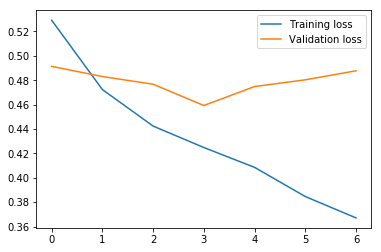

In [39]:
plt.plot(histories.history['loss'],label='Training loss')
plt.plot(histories.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

In [60]:
a_mean,a_std=np.mean(histories.history['accuracy']),np.std(histories.history['accuracy'])
l_mean,l_std=np.mean(histories.history['loss']),np.std(histories.history['loss'])
av_mean,av_std=np.mean(histories.history['val_accuracy']),np.std(histories.history['val_accuracy'])
lv_mean,lv_std=np.mean(histories.history['val_loss']),np.std(histories.history['val_loss'])
print('RNN (BiLSTM)')
print('Training')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(a_mean,a_std,l_mean,l_std))
print('Validation')
print('Accuracy : %0.3f (+-%0.3f) Loss : %0.3f (+-%0.3f)'%(av_mean,av_std,lv_mean,lv_std))

RNN (BiLSTM)
Training
Accuracy : 0.795 (+-0.031) Loss : 0.443 (+-0.049)
Validation
Accuracy : 0.783 (+-0.006) Loss : 0.470 (+-0.008)


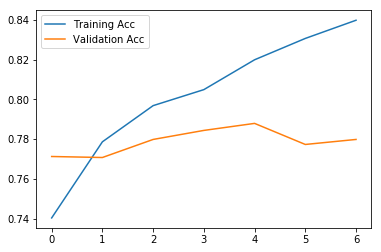

In [41]:
plt.plot(histories.history['accuracy'],label='Training Acc')
plt.plot(histories.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.show()

In [61]:
def float_int(x):
    if x-int(x)>=0.5:
        return 1
    else :
        return 0
y_pred=np.array([[float_int(i[0])] for i in mods.predict(tokenized_test)])

In [63]:
from sklearn.metrics import classification_report,confusion_matrix
test_loss,test_accuracy=mods.evaluate(tokenized_test,y_test)
print('Test Loss : %0.3f'%test_loss)
print('Test Accuracy : %0.3f'%test_accuracy)
print(classification_report(y_test,y_pred))

Test Loss : 0.499
Test Accuracy : 0.770
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1726
           1       0.74      0.70      0.72      1244

    accuracy                           0.77      2970
   macro avg       0.76      0.76      0.76      2970
weighted avg       0.77      0.77      0.77      2970

